# Random Lines Generation

We generate multiple random lines to split the input space in different clusters. The idea is to have a set of lines that split the input space in different clusters. The number of lines is a parameter that can be changed; then we get a centroid for each cluster. The number of clusters is the number of lines plus one. The centroid is the point that represents the cluster in the aggregated model. The weight of the centroid is the number of points in the cluster. The weight is the number of hours that correspond to that marginal cost.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import testbed
import random_planes

import importlib
import random_planes  # replace with your module name

importlib.reload(random_planes)
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# We can export the variables, first create a folder and then export the results
slvr = 'gurobi'     # change according to the solver installed in your machine

results_complete = testbed.run_complete_case(folder='data', case='complete_single_node.xlsx', solver=slvr)
# exporting the solution
df_complete, df_hourly = testbed.export_complete_solution(results_complete, 'complete_single_node')

# this is not the best way, but a quick and dirty one
df_cf = pd.read_excel(os.path.join('data', 'complete_single_node.xlsx'), sheet_name='cap_factors')
df_demand = pd.read_excel(os.path.join('data', 'complete_single_node.xlsx'), sheet_name='demand')
df_input = pd.merge(left=df_demand, left_on='period', right=df_cf, right_on='period')

### Grouping the Hours
Now let's group together the hours with the same marginal cost

In [3]:
sort = True
full_random = False

num_lines = 4
# np.random.seed(678)

df_input_copy = df_input.copy()
df_input_copy['basis'] = 0
df_input_copy['weight'] = 0

df_input_copy['demand'] = df_input_copy['demand'] / 1000
basis_w = []



lines = [random_planes.generate_random_line(full_random) for _ in range(num_lines)]
if sort:
    lines = sorted(lines, key=lambda line: line[1])
groups = random_planes.classify_points(df_input_copy, lines)

l_groups = df_input_copy['basis'].unique()
i = 0
for group in l_groups:
    idx_basis = df_input_copy['basis'] == group
    df_input_copy.loc[idx_basis, 'weight'] = idx_basis.sum()
    i = i + 1

# reverse the normalization
# df_input_copy['demand'] = df_input_copy['demand'] * 1000

In [4]:
df_input_copy.basis.unique()

array([2, 1, 3, 4, 0], dtype=int64)

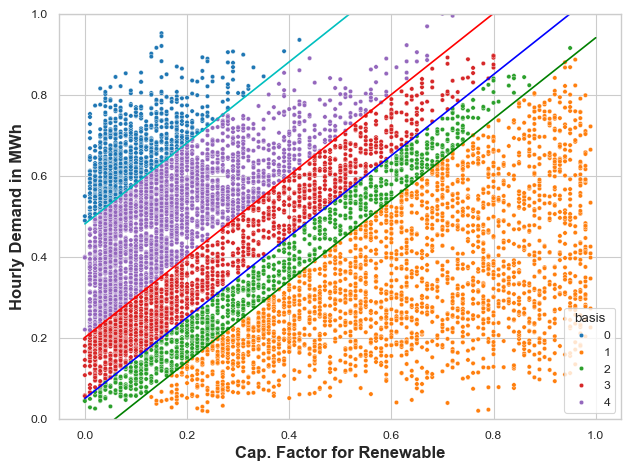

In [5]:
sns.set_style(style='whitegrid')
sns.set_context(context='paper')
df_input_copy['basis'] = df_input_copy['basis'].astype('category')
ax = sns.scatterplot(df_input_copy, y='demand', x='cap_factor', hue=df_input_copy['basis'], s=10)
ax.set_xlabel('Cap. Factor for Renewable', fontdict={'weight':'bold', 'fontsize': 12})
ax.set_ylabel('Hourly Demand in MWh', fontdict={'weight': 'bold', 'fontsize': 12})

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
x_values = np.linspace(0, 1, 100)
# Plot each line
eff_lines = random_planes.get_effective_lines(df_input_copy, lines)
for i, line in enumerate(eff_lines):
    slope, intercept = line
    y_values = slope * x_values + intercept
    ax.plot(x_values, y_values, color=colors[i % len(colors)])

plt.ylim(0, 1)
plt.tight_layout()
plt.show()


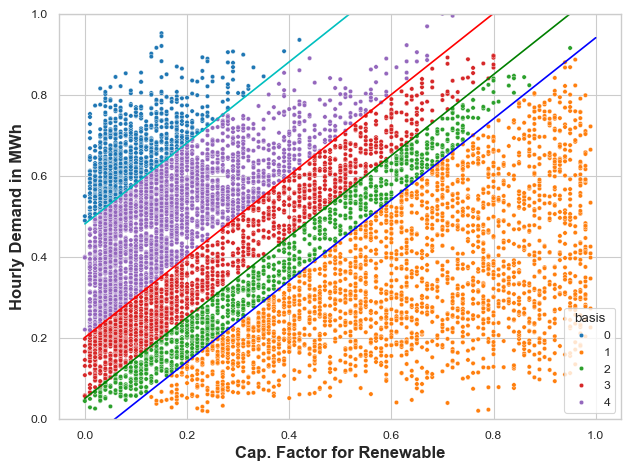

In [7]:
sns.set_style(style='whitegrid')
sns.set_context(context='paper')
df_input_copy['basis'] = df_input_copy['basis'].astype('category')
ax = sns.scatterplot(df_input_copy, y='demand', x='cap_factor', hue=df_input_copy['basis'], s=10)
ax.set_xlabel('Cap. Factor for Renewable', fontdict={'weight':'bold', 'fontsize': 12})
ax.set_ylabel('Hourly Demand in MWh', fontdict={'weight': 'bold', 'fontsize': 12})

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
x_values = np.linspace(0, 1, 100)
# Plot each line

for i, line in enumerate(lines):
    slope, intercept = line
    y_values = slope * x_values + intercept
    ax.plot(x_values, y_values, color=colors[i % len(colors)])

plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [8]:
df_input_copy['demand'] = df_input_copy['demand'] * 1000

In [9]:
eff_lines

[(1, 0.050083583529959785),
 (1, -0.05920604201144519),
 (1, 0.20077929128192917),
 (1, 0.4813432270563214)]

### Centroid Calculation
For each of these groups, calculate a centroid

In [10]:
df_basis_centroids = df_input_copy.groupby('basis').agg({'cap_factor': ['mean'],'demand': ['mean'], 'weight': ['max']})
df_basis_centroids.reset_index(drop=False, inplace=True) # to have the week as a data column and not as index
df_basis_centroids.columns = ['_'.join(col) for col in df_basis_centroids.columns]
df_basis_centroids = df_basis_centroids.rename(columns={'cap_factor_mean': 'cap_factor', 'demand_mean':'demand', 'weight_max':'weight'}).drop(columns=['basis_'])

### Aggregated Model
Create an aggregated model using the centroids, in this case the weights are the number of hours that correspond to that marginal cost

In [11]:
import os

folder_name = 'random_lines_ext'
if not os.path.exists(os.path.join('data', folder_name)):
    os.makedirs(os.path.join('data', folder_name))
    
df_config_ext = testbed.generate_config(df_basis_centroids, folder=folder_name)
df_basis_centroids

,cap_factor,demand,weight
0,0.090705,652.884482,1022
1,0.634827,343.000491,2250
2,0.356714,354.617471,983
3,0.226542,352.484196,1744
4,0.156259,492.619579,2737


### Running the Models
Now is time to run the aggregated and compare its results with the complete one

In [12]:
results = testbed.basis_execution(folder=os.path.join('data', folder_name), # location of the aggregated model
                                  solver=slvr, file='config_auto.xlsx')              # configuration file with aggregation information
df_agg_ext = testbed.export_aggregated_solution(results, folder_name)
df_comparison_ext = testbed.export_model_comparison(df_complete, df_agg_ext)
df_comparison_ext



,result,complete,aggregated,delta,rel_delta
0,of_value,7.000903e+08,6.085750e+08,9.151533e+07,0.130719
1,thermal,2.378023e+06,2.293482e+06,8.454058e+04,0.035551
2,renewable,1.244741e+06,1.347240e+06,-1.024994e+05,-0.082346
3,nsp,1.278567e+05,1.098979e+05,1.795877e+04,0.140460
4,decision_vars,2.620800e+04,1.500000e+01,2.619300e+04,0.999428


In [29]:

l_results = []


for jj in range(0, 15):
    print('Ejecutando iteración {0}'.format(jj))
    sort = True
    full_random = False
    
    num_lines = 8
    # np.random.seed(678)
    
    df_input_copy = df_input.copy()
    df_input_copy['basis'] = 0
    df_input_copy['weight'] = 0
    
    df_input_copy['demand'] = df_input_copy['demand'] / 1000
    basis_w = []
    
    
    
    lines = [random_planes.generate_random_line(full_random) for _ in range(num_lines)]
    if sort:
        lines = sorted(lines, key=lambda line: line[1])
    groups = random_planes.classify_points(df_input_copy, lines)
    
    l_groups = df_input_copy['basis'].unique()
    i = 0
    for group in l_groups:
        idx_basis = df_input_copy['basis'] == group
        df_input_copy.loc[idx_basis, 'weight'] = idx_basis.sum()
        i = i + 1
    
    eff_lines = random_planes.get_effective_lines(df_input_copy, lines)
    
    df_input_copy['demand'] = df_input_copy['demand'] * 1000
    
    df_basis_centroids = df_input_copy.groupby('basis').agg({'cap_factor': ['mean'],'demand': ['mean'], 'weight': ['max']})
    df_basis_centroids.reset_index(drop=False, inplace=True) # to have the week as a data column and not as index
    df_basis_centroids.columns = ['_'.join(col) for col in df_basis_centroids.columns]
    df_basis_centroids = df_basis_centroids.rename(columns={'cap_factor_mean': 'cap_factor', 'demand_mean':'demand', 'weight_max':'weight'}).drop(columns=['basis_'])
    
    folder_name = 'random_lines_ext'
    if not os.path.exists(os.path.join('data', folder_name)):
        os.makedirs(os.path.join('data', folder_name))
    
    df_config_ext = testbed.generate_config(df_basis_centroids, folder=folder_name)
    df_basis_centroids
    
    results = testbed.basis_execution(folder=os.path.join('data', folder_name), # location of the aggregated model
                                      solver=slvr, file='config_auto.xlsx')              # configuration file with aggregation information
    df_agg_ext = testbed.export_aggregated_solution(results, folder_name)
    df_comparison_ext = testbed.export_model_comparison(df_complete, df_agg_ext)
    df_comparison_ext
    
    l_results.append(df_comparison_ext.iloc[0, :])


Ejecutando iteración 0
Ejecutando iteración 1
Ejecutando iteración 2
Ejecutando iteración 3
Ejecutando iteración 4
Ejecutando iteración 5
Ejecutando iteración 6
Ejecutando iteración 7
Ejecutando iteración 8
Ejecutando iteración 9
Ejecutando iteración 10
Ejecutando iteración 11
Ejecutando iteración 12
Ejecutando iteración 13
Ejecutando iteración 14


In [31]:
df_aux = pd.concat(l_results, axis=1)
df_aux.iloc[4, :]

0    0.095856
0    0.682793
0    0.909292
0     0.12027
0    0.351513
0    0.246533
0    0.909446
0    0.104355
0    0.198207
0    0.563735
0    0.566521
0    0.082425
0    0.344995
0    0.088634
0    0.558097
Name: rel_delta, dtype: object

Text(0.5, 1.0, 'Percentage error')

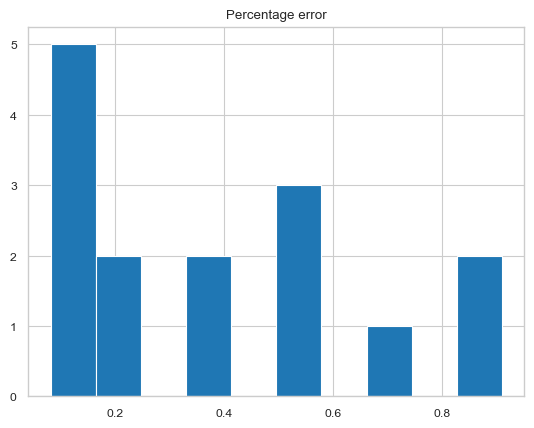

In [39]:

df_aux.iloc[4, :].hist()
plt.title('Percentage error')

Text(0.5, 1.0, 'Aggregated OF value')

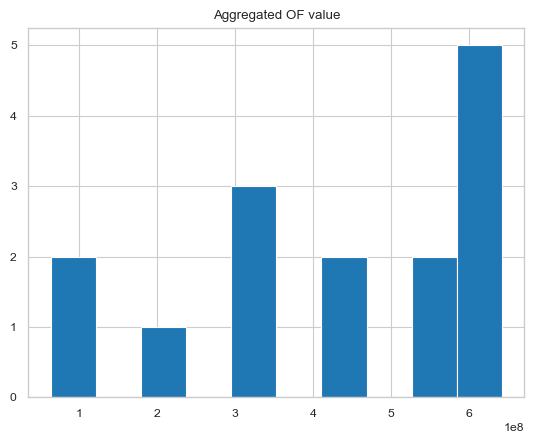

In [38]:
df_aux.iloc[2, :].hist()
plt.title('Aggregated OF value')

In [ ]:
df_aux
df_aux.iloc[2, :]